In [ ]:
# %%capture
!pip install super-gradients
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade
!pip install tensorboard

In [10]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from IPython.display import clear_output
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models
import sys
sys.stdout = sys.__stdout__ # it is done to resolve the error of models  import



In [ ]:
CHECKPOINT_DIR = 'models'
trainer = Trainer(experiment_name='Face_Detection', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J2oXQYdxNrLyHup9hN3J")
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
dataset = project.version(13).download("yolov5")


In [12]:
dataset_params = {
    'data_dir':'/content/Face-Detection-13',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Face']
}


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
train_data.dataset.transforms

In [6]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data,
              )

In [13]:
best_model = models.get('yolo_nas_l ',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="Face_Detection/content/drive/MyDrive/models/Face_Detection/RUN_20231130_121552_285960/average_model.pth")


In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

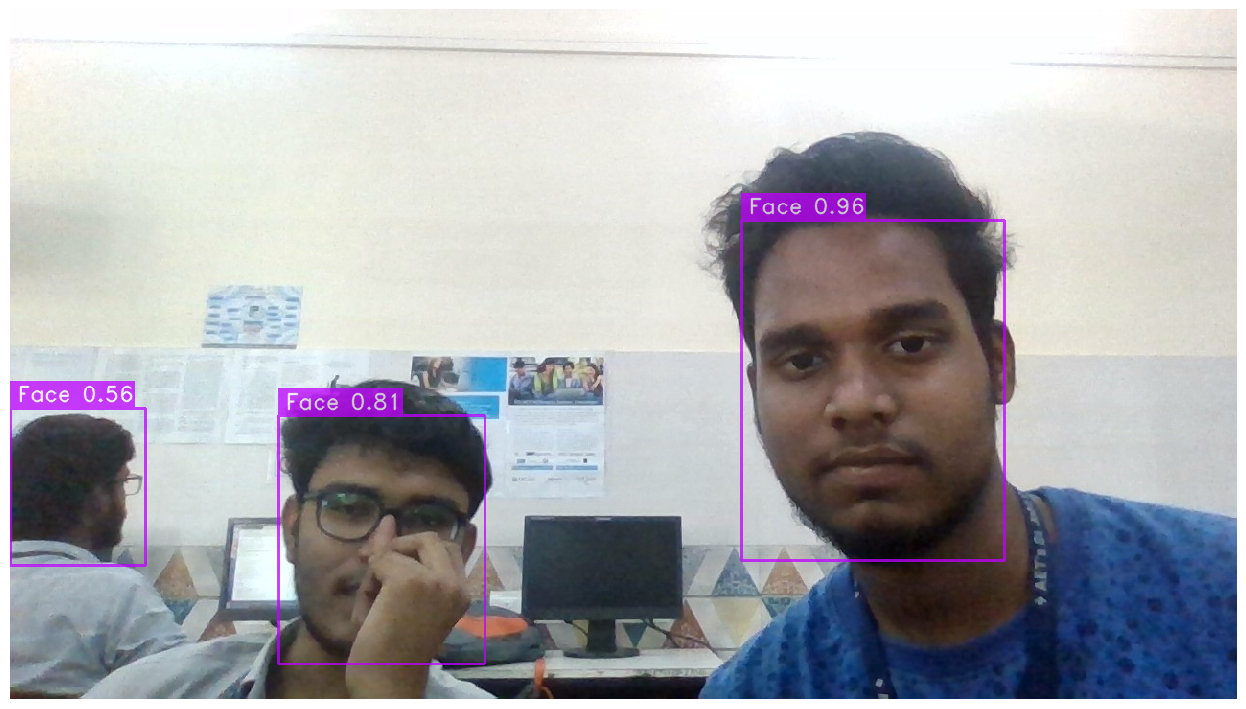

In [14]:
img_url = 'WIN_20221006_13_24_51_Pro.jpg'
images_predictions = best_model.predict(img_url)
images_predictions.show()

In [7]:
"Number of image predictions: ", len(images_predictions)


('Number of image predictions: ', 1)

In [19]:
for image_prediction in images_predictions:
    class_names = image_prediction.class_names
    labels = image_prediction.prediction.labels
    confidence = image_prediction.prediction.confidence
    bboxes = image_prediction.prediction.bboxes_xyxy

    for i, (label, conf, bbox) in enumerate(zip(labels, confidence, bboxes)):
        print("prediction: ", i)
        print("label_id: ", label)
        print("label_name: ", class_names[int(label)])
        print("confidence: ", conf)
        print("bbox: ", bbox)
        print("--" * 10)

        # You can use the detection results for various tasks, such as:
        # - Filtering objects based on confidence scores or labels
        # - Analyzing object distributions within the images
        # - Calculating object dimensions or areas
        # - Implementing custom visualization techniques
        # - ...


In [7]:
import torch
best_model = best_model.to("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
image_prediction = best_model.predict_webcam()
print(image_prediction)

'hello'